# Build Mesh classifier datasets

Builds a three-column dataframes:
 - term: term from either the DEFT dataset or MEsh terminology
 - label: Mesh code C**
 - term source: "DEFT-train", "DEFT-val", "Mesh-FR", "Mesh-EN"

In [1]:
from os.path import isfile, isdir, join
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
import math

IN_BRAT_DIR = '../../data/release/train2021/'
IN_TRAIN_FILE = '../../data/work/classes-train-train.txt'
IN_DEV_FILE = '../../data/work/classes-train-val.txt'
IN_FR_MESH_FILE = '../../resources/terminologie_MeSH_DEFT2021.xlsx'

OUT_DF = '../../resources/mesh_term_dataset.pkl'

assert isdir(IN_BRAT_DIR)
assert isfile(IN_TRAIN_FILE)
assert isfile(IN_FR_MESH_FILE)
assert isfile(IN_DEV_FILE)

In [2]:
deft_dfs = {}
labels = set()
for source, f in zip(['DEFT-train', 'DEFT-val'], [IN_TRAIN_FILE, IN_DEV_FILE]):
    labels_df = pd.read_csv(f, sep='\t', header=None, names=['file', 'label', 'desc'])
    labels |= set(labels_df['label'].unique())
    files = labels_df['file'].unique()
    deft_dfs[source] = (labels_df, files)

In [3]:
def find_offsets_relaxed_match(label_infos, left_offset, right_offset):
    matches = []
    for o in label_infos.keys():
        o_list = o.split(' ')
        leftmost_offset = int(o_list[0])
        rightmost_offset = int(o_list[-1])
        if leftmost_offset <= left_offset <= rightmost_offset or leftmost_offset <= right_offset <= rightmost_offset or left_offset <= leftmost_offset <= right_offset or left_offset <= rightmost_offset <= right_offset:
            matches.append((o, label_infos[o]))
    return matches

In [4]:
ENTITY_REGEX = re.compile('^(T\d+)\t([^ ]+) ([^\t]+)\t(.*)$')

tags = []
data = []

for source, source_infos in deft_dfs.items():
    files = source_infos[1]
    for ann_file in files:
        #if '-24-' not in ann_file:
        #    continue
        ann_path = join(IN_BRAT_DIR, ann_file)
        assert isfile(ann_path)
        # Read ann file
        with open(ann_path, 'r', encoding='utf-8') as f_in:
            lines = f_in.readlines()

        # Read corresponding txt file
    #    txt_path = join(IN_BRAT_DIR, ann_file[:-4] + ".txt")
    #    assert isfile(txt_path)
    #    text = open(txt_path, 'r', encoding='utf-8').read()
        columns = ['term', 'label', 'source']

        # First pass -> extract all labels (i.e entity with Mesh-like tags)
        label_infos = {}
        other_infos = {}
        for line in lines:
            entity_match = ENTITY_REGEX.match(line.strip())
            if entity_match is not None:
                ann_id = entity_match.group(1)
                label = entity_match.group(2)
                offsets = entity_match.group(3)
                span = entity_match.group(4)
                if label in labels:
                    label_list = label_infos.get(offsets, [])
                    label_list.append((ann_id, label, offsets, span))
                    label_infos[offsets] = label_list
                    data.append([span, label, source])

        # Find other mentions with the same offsets
        # restrict to pathology and sosy
        for line in lines:
            entity_match = ENTITY_REGEX.match(line.strip())
            if entity_match is not None:
                ann_id = entity_match.group(1)
                label = entity_match.group(2)
                offsets = entity_match.group(3)
                offset_list = offsets.split(' ')
                leftmost_offset = int(offset_list[0])
                rightmost_offset = int(offset_list[-1])
                span = entity_match.group(4)
                if label not in labels:
                    if label in ('pathologie', 'sosy'):
                        res = find_offsets_relaxed_match(label_infos, leftmost_offset, rightmost_offset)
                        if len(res):
                            for r in res:
                                new_offsets, mesh_tags = r
                                for i in mesh_tags:
                                    assert i[1] in labels
                                    data.append([span, i[1], source])
                                #tags.append([ann_file, ann_id, new_offsets, span, label, mesh_tags])
                        #else:                        
                        #    tags.append([ann_file, ann_id, offsets, span, label, None])

    #    for offsets in label_infos.keys():
    #        offset_df = [t for t in tags if t[2] == offsets]
    #        if not len(offset_df):
    #            offset_list = offsets.split(' ')
    #            leftmost_offset = int(offset_list[0])
    #            rightmost_offset = int(offset_list[-1])
    #            span = text[leftmost_offset:rightmost_offset]
    #            tags.append([ann_file, ann_id, offsets, span, 'null', ', '.join([i[1] for i in label_infos[offsets]])])
    #     
#tag_df = pd.DataFrame(data=tags, columns=['ann_file', 'ann_id', 'offsets', 'span', 'label', 'tag'])


## Add Mesh files

In [5]:
mesh_df = pd.read_excel(IN_FR_MESH_FILE)

In [6]:
for i, raw in mesh_df.iterrows():
    label = raw['Labels']
    if type(label) != str and math.isnan(label):
        continue
    if type(label) == str and label == '':
        continue
    assert label in labels, f'{i} - {label}'
    term = raw['Entité/term/expression régulière'].strip()
    source = 'Mesh-FR'
    data.append([term, label, source])

In [7]:
dataset_df = pd.DataFrame(data=list(data), columns=columns)
dataset_df = dataset_df.drop_duplicates().reset_index(drop=True)
dataset_df

,term,label,source
0,épileptique,nerveux,DEFT-train
1,légère somnolence,etatsosy,DEFT-train
2,10 fois la dose,chimiques,DEFT-train
3,vomissements,etatsosy,DEFT-train
4,retard de croissance intra-utérin,etatsosy,DEFT-train
...,...,...,...
9378,Tendinopathie,blessures,Mesh-FR
9379,Traumatisme,blessures,Mesh-FR
9380,Troubles dus à la chaleur,blessures,Mesh-FR
9381,Tumeurs radio-induites,blessures,Mesh-FR


In [27]:
# save
dataset_df.to_pickle(OUT_DF)

In [30]:
dataset_df[dataset_df['term'] == 'retard de croissance intra-utérin']

,term,label,source
4,retard de croissance intra-utérin,etatsosy,DEFT-train
5,retard de croissance intra-utérin,genetique,DEFT-train
6,retard de croissance intra-utérin,femme,DEFT-train


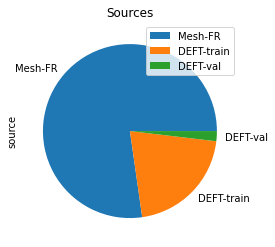

In [20]:
ax = dataset_df['source'].value_counts().plot(kind='pie',
                                    #figsize=(14,8),
                                              legend=True,
                                              title="Sources")
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (0.1+(p.get_x() * 1.005), p.get_height() * 1.01))


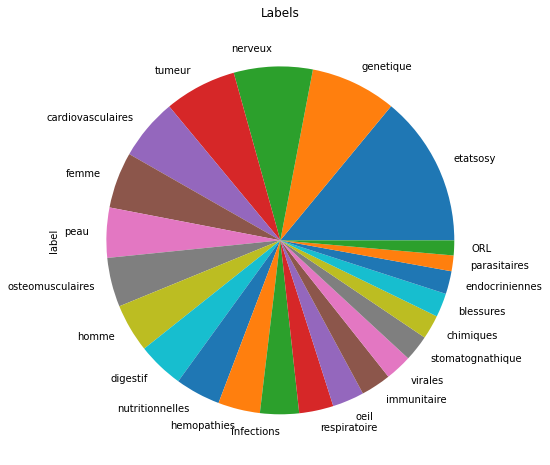

In [31]:
ax = dataset_df['label'].value_counts().plot(kind='pie',
                                             figsize=(14,8),
                                             title="Labels")
